# Fully convolutional network for semantic segmentation

## Set up Google Colab

### Connect with Google drive 

In [0]:
from google.colab import drive 
drive.mount('/bdrive')

### Go to the project directory

In [2]:
%cd ./../bdrive/My Drive/app/Hair-segmentation
%ls

/bdrive/My Drive/app/Hair-segmentation
data/  FCN.ipynb  fcn.pth  images/  Original.ipynb


### Confirm that PIL works

In [0]:
from PIL import Image
Image.open(open("images/works.jpg","rb"))

In [0]:
# If PIL didn't work, run this cell and avoid the next
! which pillow
! pip uninstall pillow
! which pip
! /usr/local/bin/pip uninstall pip
! apt-get update
! apt-get install python3-pip
! pip3 install --upgrade pip
! pip3 install torch torchvision

### Install packages

In [0]:
!pip install torch torchvision

## Imports 

In [0]:
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import random

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG
from torch.utils.data import Dataset

## Data

### Test on Camvid dataset

In [0]:
class CamVid(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
    if phase == 'train':
      self.input_shape = (480, 640)
    elif phase == 'valid':
      self.input_shape = (704, 960)
  
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = scipy.misc.imread("data/"+image, mode='RGB')
    label = np.load("data/"+label)
        
    if self.phase == "train":
      # RandomCrop
      h, w, _ = image.shape
      new_h, new_w = self.input_shape
      
      top = random.randint(0, h - new_h)
      left = random.randint(0, w - new_w)

      image = image[top:top + new_h, left:left + new_w]
      label = label[top:top + new_h, left:left + new_w]
      
      # RandomHorizontalFlip
      if random.random() < 0.5:
        image = np.fliplr(image)
        label = np.fliplr(label)
        
    if self.phase == "valid":
      # Resize
      new_h, new_w = self.input_shape
      
      image = image[0:new_h, 0:new_w]
      label = label[0:new_h, 0:new_w]
          
    # Normalization 
    mean=[0.485, 0.456, 0.460]
    std =[0.229, 0.224, 0.225]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]
    
    # ToTensor 
    image = torch.from_numpy(image.copy()).float()
    label = torch.from_numpy(label.copy()).long()
  
    # One-hot encoding 
    h, w = label.size()
    target = torch.zeros(32, h, w)
    for c in range(32):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label} 
  
  def __len__(self):
    return len(self.data) 

train_data = CamVid('./data/CamVid/train.csv', phase="train")
valid_data = CamVid('./data/CamVid/valid.csv', phase="valid")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)

### Visualize a single batch

torch.Size([5, 3, 480, 640]) torch.Size([5, 32, 480, 640]) torch.Size([5, 480, 640])


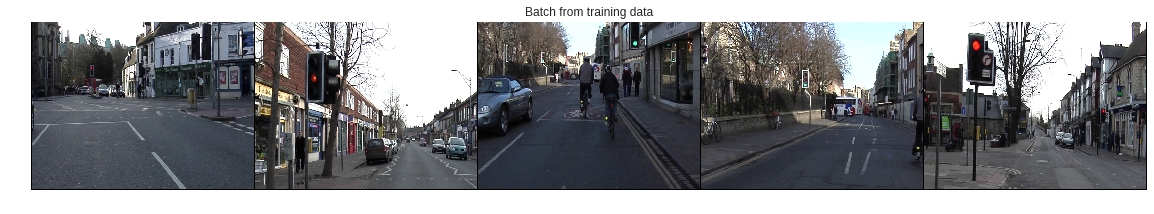

In [7]:
def show_batch(batch):
  mean=[0.485, 0.456, 0.460]
  std =[0.229, 0.224, 0.225]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)

## Model

### Encoder 

In [0]:
class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

In [0]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [0]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

###  Test output sizes

In [11]:
batch_size, n_classes, h, w = 10, 20, 160, 160

encoder = VGG16(cfg, ranges, requires_grad=True)
decoder = FCN8s(encoder, n_classes)

enc_input = torch.randn(batch_size, 3, 224, 224)
dec_input = torch.randn(batch_size, 3, h, w)

enc_output = encoder(enc_input)
dec_output = decoder(dec_input)

assert enc_output['pool5'].size() == torch.Size([batch_size, 512, 7, 7])
assert dec_output.size() == torch.Size([batch_size, n_classes, h, w])
print("Correct output sizes")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 61666360.74it/s]


Correct output sizes


## Train model

### Test if the model works using a single batch

In [0]:
fcn = FCN8s(VGG16(cfg,ranges), n_classes)

criterion = nn.BCELoss()
optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(batch_size, 3, h, w)
y = torch.randn(batch_size, n_classes, h, w)
y = torch.tensor(y, requires_grad=False)

for i in range(3):
  optimizer.zero_grad()
  output = fcn(x)
  output = torch.sigmoid(output)
  loss = criterion(output, y)
  loss.backward()
  print("i: {}, loss: {:.5f}".format(i, loss.item()))
  optimizer.step()

### Set training parameters

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [0]:
# Define model
n_classes = 32
model = FCN8s(VGG16(cfg, ranges), n_classes)
model.to(device)

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 5
print_every = 10

# Define scores
IoU_scores = np.zeros((epochs, n_classes))
pixel_scores = np.zeros(epochs)

### Check accuracy before training

In [0]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, validloader, criterion):
  total_ious = []
  pixel_accs = []
  for i, batch in enumerate(validloader):
    inputs = batch['x'].to(device)
    output = model(inputs)
    output = output.data.cpu().numpy()
        
    N, _, h, w = output.shape 
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
    target = batch['l'].cpu().numpy().reshape(N, h, w)
    
    for y_hat, y in zip(pred, target):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  return pixel_acc, mean_iou

In [19]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, validloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.01654981737012987  Mean IoU:  0.0006759165394627491


### Train

In [21]:
for epoch in range(epochs):
  for i, batch in enumerate(trainloader):
    inputs, labels = batch['x'].to(device), batch['y'].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        paccuracy, meaniou = validation(model, validloader, criterion)
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training loss: {:.5f}.. ".format(loss.item()),
              "Pixel accuracy.. {:.5f}".format(paccuracy),
              "Mean IU.. {:.5f}".format(meaniou))
  torch.save(model.state_dict(), "./fcn.pth")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


Epoch: 1/5..  Training loss: 0.71643..  Pixel accuracy.. 0.01471 Mean IU.. 0.00204
Epoch: 1/5..  Training loss: 1156.56262..  Pixel accuracy.. 0.00715 Mean IU.. 0.00101
Epoch: 1/5..  Training loss: 0.61652..  Pixel accuracy.. 0.10757 Mean IU.. 0.01010
Epoch: 1/5..  Training loss: 0.33305..  Pixel accuracy.. 0.18230 Mean IU.. 0.01461
Epoch: 1/5..  Training loss: 0.23662..  Pixel accuracy.. 0.21339 Mean IU.. 0.01610
Epoch: 1/5..  Training loss: 0.18411..  Pixel accuracy.. 0.23233 Mean IU.. 0.01708
Epoch: 1/5..  Training loss: 0.13437..  Pixel accuracy.. 0.21517 Mean IU.. 0.01614
Epoch: 1/5..  Training loss: 0.12281..  Pixel accuracy.. 0.23125 Mean IU.. 0.01543
Epoch: 1/5..  Training loss: 0.12286..  Pixel accuracy.. 0.24293 Mean IU.. 0.01565
Epoch: 1/5..  Training loss: 0.12999..  Pixel accuracy.. 0.23035 Mean IU.. 0.01550
Epoch: 1/5..  Training loss: 0.12125..  Pixel accuracy.. 0.21335 Mean IU.. 0.01494
Epoch: 1/5..  Training loss: 0.12469..  Pixel accuracy.. 0.23288 Mean IU.. 0.01520
E

### Check accuracy afte training 

In [0]:
model.eval()
pixel_acc, mean_iou = validation(model, validloader, criterion)
print("Pixel accuracy: ", pixel_accs, " Mean IoU: ", mean_iou)

### Save model

In [0]:
torch.save(model.state_dict(), "./fcn.pth")

## Make inference

In [0]:
state_dict = torch.load('./fcn.pth')
model.load_state_dict(state_dict)

In [0]:
def load_image(path):
  image = Image.open(path)
  #image = valid_transforms(image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

model.to("cpu")
model.eval()
image = load_image("data/CamVid/701_StillsRaw_full/0001TP_006750.png")
prediction = model(image)

print(prediction)

In [0]:

#print(prediction.detach().numpy())
pred = prediction.detach().numpy()
plt.plot(pred[0][2], pred[0][3])
plt.show()